# Supernova Classification with Machine Learning
## Dr. Michelle Lochner

This tutorial aims to give an introduction to the principles of basic machine learning, using an example problem of supernova classification. 

This is based on: <br>
["Photometric Supernova Classification With Machine Learning"](https://arxiv.org/abs/1603.00882), Lochner et al. (2016)  <br>

And [this](https://github.com/MichelleLochner/ml-tutorial) even simpler tutorial.

*Further reading (see notes for more detailed references)*
- [sncosmo](https://sncosmo.readthedocs.io)
- [scikit-learn](http://scikit-learn.org/)
- The supernova classification [challenge](https://arxiv.org/abs/1001.5210) and [results](https://arxiv.org/abs/1008.1024)
- [SALT2 template fitting](https://arxiv.org/abs/astro-ph/0701828)

**Note:** If you're not an astronomer, don't worry too much if this is a little unfamiliar to you. This is just an illustration of the process commonly followed in supervised machine learning. I provide a set of features that you can work with but I do still detail the process of how those features are extracted from data, just to give you an example.

## Background

Supernovae are the explosive deaths of stars. We detect them as *transient* events in data from optical telescopes. 

Supernova classification is a hot topic in astronomy at the moment. It's well known that there are several types of supernovae and to a cosmologist, only one of them is really useful: a Ia. Astrophysicists studying supernovae also need to know if they're dealing with a core collapse or Ia supernova. The problem is, traditionally the only way to truly accurately type a supernova is with a spectrum. In current and future surveys such as LSST, there will be simply too many supernovae detected to follow them up spectroscopically. If we want to make use of this large dataset of photometric supernovae, we need a way to automatically classify them based on photometry alone (that is the light curve of the supernova in several different colour filters).

Since we will generally have a small training set of supernovae that have been spectroscopically typed, this is a great problem for supervised machine learning.

In this tutorial, you will go through the same procedure as you would for any supervised machine learning problem. You will first extract meaningful, scientifically driven features from raw data. You will decide how to split your data into training, validation and test sets. And finally, you will choose a machine learning algorithm to classify the supernovae and evaluate the results. 

**Data**<br>
The data we will use is the same as in Lochner et al. (2016), a subset of simulations from the Photometric Supernova Classification Challenge (SPCC, Kessler et al. 2010). The data consists of light curves (brightness as a function of time) in four different filter bands (i.e. different colours), with metadata including the type and the redshift. I have provided a subset of the data in an astropy table format.

**Features**<br>
The *features* we will use will be from a SALT-II model fit (Guy et al. 2007), which is an empirically determined model (based on spectral time series data) with 5 parameters:<br>
z - supernova redshift<br>
t0 - time of peak flux<br>
x0 - related to amplitude of the supernova<br>
x1 - related to the stretch of the supernova<br>
c - related to the colour of the supernova<br>

The package `sncosmo` can be used to fit these features to each light curve in the dataset. We expect it to fit well for Ia's and not so well for non-Ia's. 

**Classification**<br>
We'll use `sklearn` for classification. It will be up to you to apply the concepts covered in the lecture, including training/test splits, cross-validation, algorithm choice and measuring performance. 

In [9]:
# You might need to install these packages
# !pip install sncosmo iminuit

In [1]:
import time
import os
import subprocess

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib widget

# Section 1: Setup

### How to read in a supernova light curve as an astropy table

Unzip the data (if not already unzipped)

In [3]:
data_root = os.path.join('data','supernovae_data','')

if not os.path.exists(data_root):
    subprocess.call(['unzip', 'data/supernovae_data.zip', '-d', 'data']) # This probably only works on linux or mac

I've saved the supernova light curves in a format that `sncosmo` can read: an astropy table. The cell below reads in a single object's data and displays the table. 

The columns are: <br>
`mjd`: Time in days since the first observation of the supernova <br>
`filter`: Which filter band the observation is in (i.e. which colour)<br>
`flux`: The flux (brightness) in that band<br>
`flux_error`: Uncertainty on the flux due to instrumental noise<br>
`zp`: Zero point (The magnitude the flux is calibrated to)<br>
`zpsys`: The system used to calibrate the flux

Here's what a light curve looks like in astropy table format:

In [4]:
lc_file = os.path.join(data_root, '34.dat')
lc = Table.read(lc_file, format='ascii')
lc

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,95.18,5.147,27.5,ab
0.008000000001629815,desr,116.1,3.062,27.5,ab
0.023999999997613486,desi,102.8,3.7,27.5,ab
0.046999999998661224,desz,103.7,3.153,27.5,ab
2.997000000003027,desg,174.7,4.272,27.5,ab
3.004000000000815,desr,176.1,3.73,27.5,ab
3.0429999999978463,desi,165.5,3.691,27.5,ab
3.0750000000043656,desz,150.9,4.676,27.5,ab
4.075000000004366,desg,192.3,4.531,27.5,ab


# Section 2: Feature extraction

In [5]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    return res[0].parameters

Let's fit one of these light curves:

In [6]:
prms = fit_supernova(lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)

Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[ 7.28385580e-01  1.98758379e+01  2.50842809e-05  2.20457380e+00
 -2.65958520e-01]


/home/michelle/venv/venv-ml-tutorial/lib64/python3.13/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: desg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


sncosmo can make a nice plot to show if the fit works well

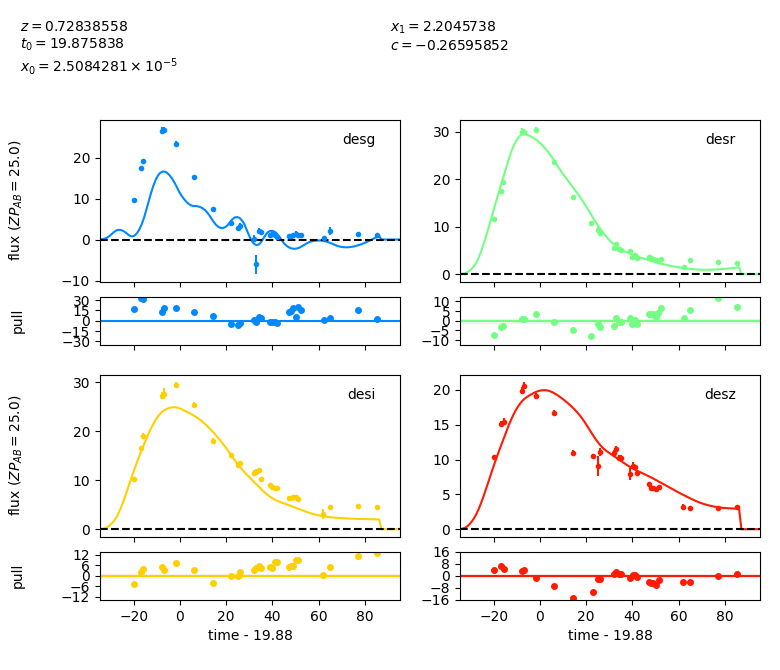

In [7]:
mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(lc, mod);

**I've already extracted features for you (because it takes a little while) in a file called "salt2_features.txt"**<br>
Load the features into a numpy array. There's another file called "labels.txt" which has the true label for each object (what we're trying to predict). The labels are:

1 - Ia<br>
2 - II<br>
3 - Ibc<br>

We'll examine metrics (like ROC curves) assuming 1 is the positive class (the class we care the most about in this case).

# Section 3: Classification

## 1. Split into training and test sets

What's a reasonable choice here for how much data should go into your test set? What are you going to do to ensure you don't overfit?

In [8]:
dataset = np.loadtxt(os.path.join('data','salt2_features.txt'), comments='#')

In [9]:
dataset.shape

(2000, 6)

## 2. Scale the features
What algorithm are you planning on using? Does it require you scale the features in any way?

## 3. Choose a machine learning algorithm and train

## 4. Run your trained algorithm to predict the labels 

## 5. Compute the accuracy, precision and recall of your classified objects
Don't use sklearn's functions here, compute these yourself to see how it's done

## 6. A better metric - create a ROC curve for your classified supernovae, with Ia as the positive class
You'll need to go back and predict the probability for each object being a Ia. You can then use sklearn's `roc_curve` and `roc_auc_score` functions. Beware: these will expect a binary classification...

## 7. What's the best you can get?
I can get an AUC of around 0.93 for this dataset. Try to see if you can beat that! Try different algorithms and hyperparameters. Think about optimising the hyperparameters, what metric should you be optimising for? Just ensure you always keep aside a test set (and maybe try different test sets) to avoid overfitting.